In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import traceback
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from collections import defaultdict

def plot_df(df, ax, column, label='', lower_cut=0):
    mean = df.T.groupby(df.T.index).mean().T
    std = df.T.groupby(df.T.index).std().T

    y = mean[column][lower_cut:]
    x = mean[column][lower_cut:].index
    ci = std[column][lower_cut:]
    ax.plot(x,y, label=label)
    ax.fill_between(x, (y-ci), (y+ci), alpha=.1)

def analyse_df(df, column, epoch):
    mean = df.T.groupby(df.T.index).mean().T
    std = df.T.groupby(df.T.index).std().T

    mean = mean[column].iloc[epoch]
    std = std[column].iloc[epoch]
    return mean, std


def parse_tensorboard(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])

    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    df = runlog_data.pivot(index='step', columns='metric')
    df.columns = df.columns.levels[1]
    df = df.reset_index(drop=True)
    return df


def find_checkpoints(string='', path="runs"):
    runs = []
    for root, dirs, files in os.walk(path):
        if string in root and files:
            checkpoint = [s for s in files if "events" in s]
            if not checkpoint:
                continue
            checkpoint = checkpoint[0]
            runs.append({
                'root': root,
                'checkpoint': checkpoint,
                'path': os.path.join(root, checkpoint),
            })
    return runs

In [2]:
runs = find_checkpoints(path='/home/cermavo3/projects/datasets/experiments/basic3/runs')
data = defaultdict(list)

for run in runs:
    df = parse_tensorboard(run['path'])
    if df.values.size > 0:
        name = run['root'].split('/')[-2][20:]
        data[name].append(df['acc'])
        data[name].append(df['acc_bal'])

dfs = {}
for k, v in data.items():
    dfs[k] = pd.DataFrame(v).T

In [3]:
results = {}
for key, data in dfs.items():
    mean, std = analyse_df(dfs[key], 'acc', epoch=-1)
    key = key.replace('_', '-')
    results[key] = f"{mean:.3f} +-{std:.3f}"

In [4]:
#latex = pd.Series(results).to_latex()
#latex

### Full vs Segmentation vs Bounding box

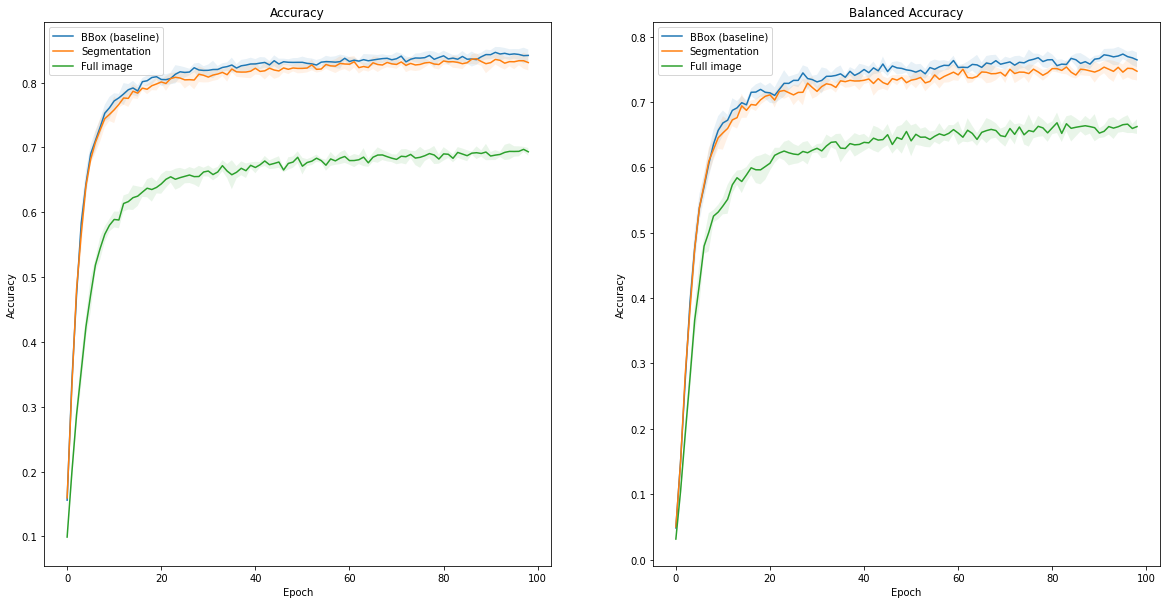

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline'], ax1, label='BBox (baseline)', column='acc')
plot_df(dfs['baseline'], ax2, label='BBox (baseline)', column='acc_bal')

plot_df(dfs['img_seg'], ax1, label='Segmentation', column='acc')
plot_df(dfs['img_seg'], ax2, label='Segmentation', column='acc_bal')

plot_df(dfs['img_full'], ax1, label='Full image', column='acc')
plot_df(dfs['img_full'], ax2, label='Full image', column='acc_bal')

ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### Augmentations
- Augmentation significantly helps stabilise training.
- Basic augmentations: rotation, flips, random jitter.

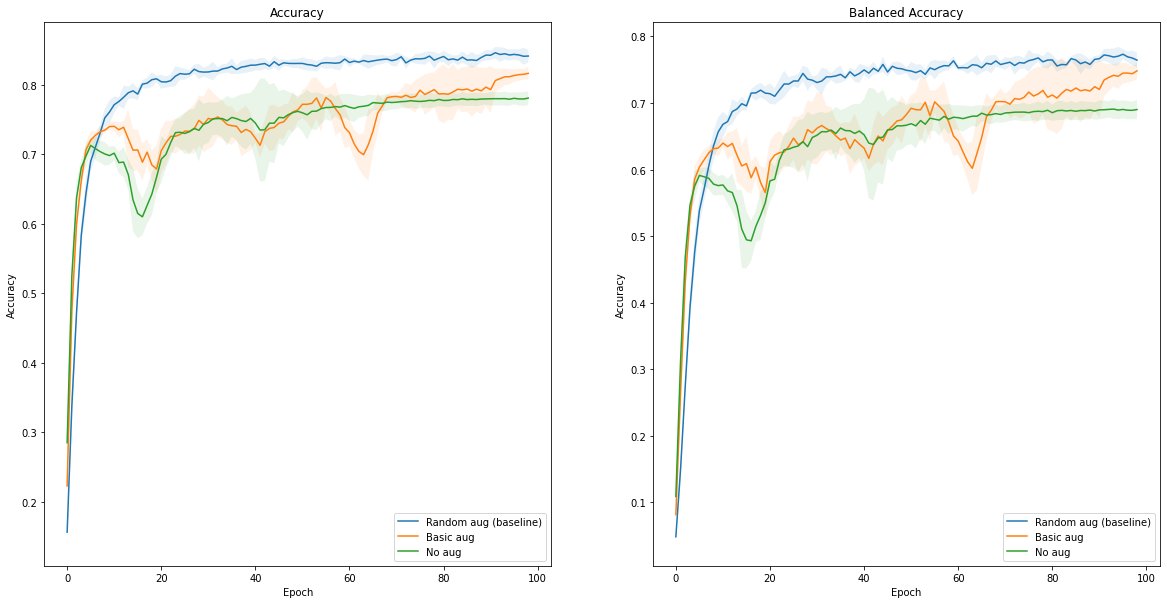

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline'], ax1, label='Random aug (baseline)', column='acc')
plot_df(dfs['baseline'], ax2, label='Random aug (baseline)', column='acc_bal')

plot_df(dfs['augment_basic'], ax1, label='Basic aug', column='acc')
plot_df(dfs['augment_basic'], ax2, label='Basic aug', column='acc_bal')

plot_df(dfs['augment_none'], ax1, label='No aug', column='acc')
plot_df(dfs['augment_none'], ax2, label='No aug', column='acc_bal')

ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### Pretrain vs fully trained

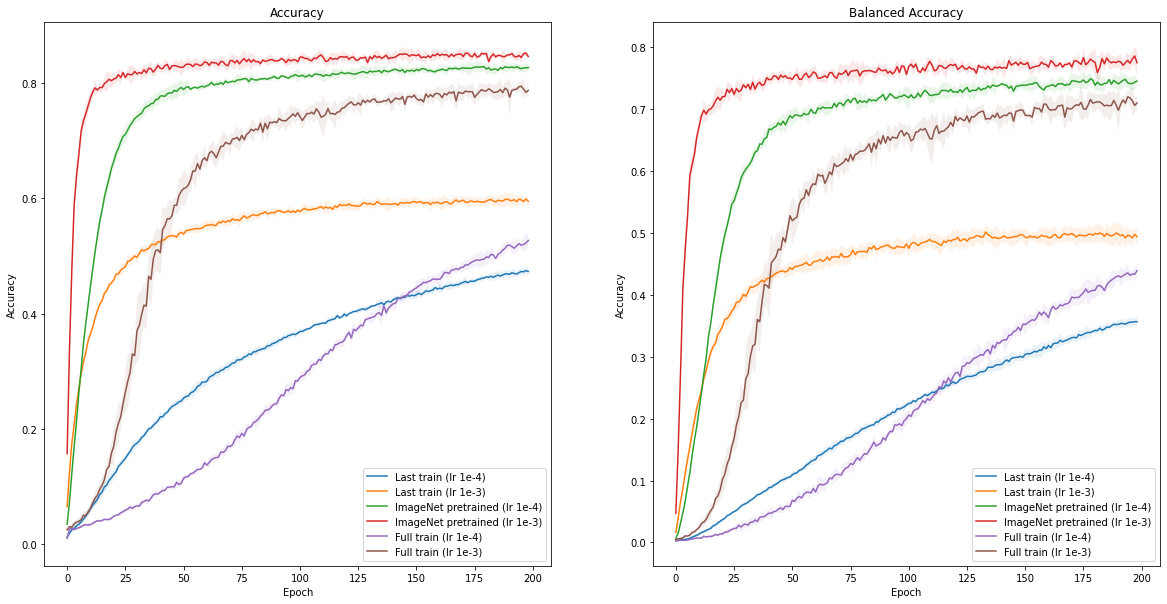

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['train_only_last-lr04'], ax1, label='Last train (lr 1e-4)', column='acc')
plot_df(dfs['train_only_last-lr04'], ax2, label='Last train (lr 1e-4)', column='acc_bal')
plot_df(dfs['train_only_last_lr03'], ax1, label='Last train (lr 1e-3)', column='acc')
plot_df(dfs['train_only_last_lr03'], ax2, label='Last train (lr 1e-3)', column='acc_bal')

plot_df(dfs['train_pretrain_lr04'], ax1, label='ImageNet pretrained (lr 1e-4)', column='acc')
plot_df(dfs['train_pretrain_lr04'], ax2, label='ImageNet pretrained (lr 1e-4)', column='acc_bal')
plot_df(dfs['train_pretrain_lr03'], ax1, label='ImageNet pretrained (lr 1e-3)', column='acc')
plot_df(dfs['train_pretrain_lr03'], ax2, label='ImageNet pretrained (lr 1e-3)', column='acc_bal')

plot_df(dfs['train_full_lr04'], ax1, label='Full train (lr 1e-4)', column='acc')
plot_df(dfs['train_full_lr04'], ax2, label='Full train (lr 1e-4)', column='acc_bal')
plot_df(dfs['train_full_lr03'], ax1, label='Full train (lr 1e-3)', column='acc')
plot_df(dfs['train_full_lr03'], ax2, label='Full train (lr 1e-3)', column='acc_bal')

ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### Categorical features

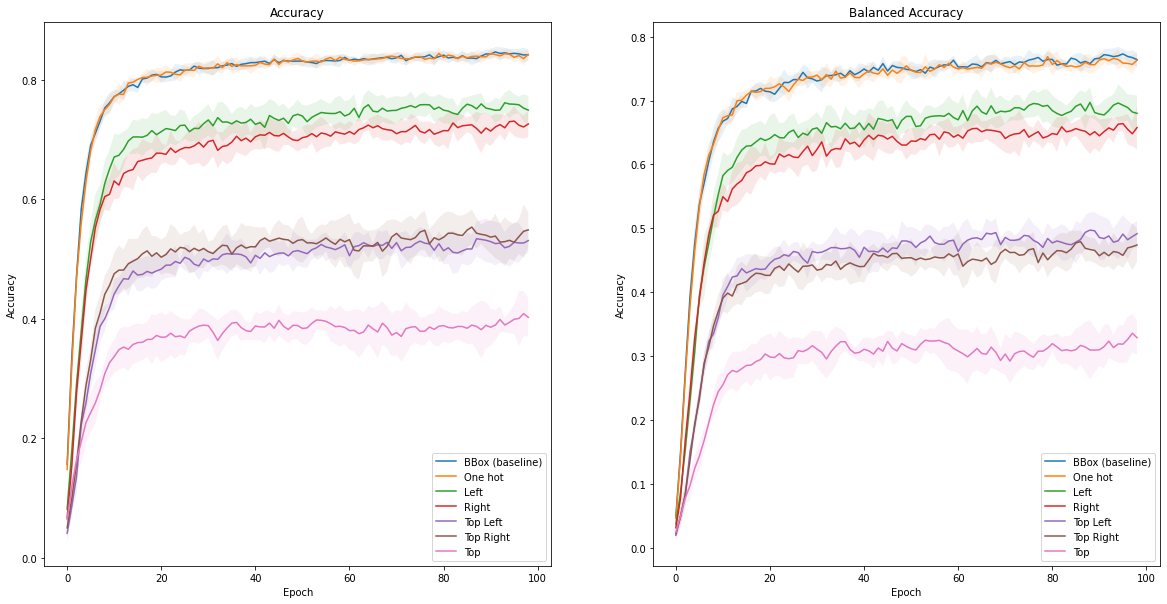

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline'], ax1, label='BBox (baseline)', column='acc')
plot_df(dfs['baseline'], ax2, label='BBox (baseline)', column='acc_bal')

plot_df(dfs['features_onehot'], ax1, label='One hot', column='acc')
plot_df(dfs['features_onehot'], ax2, label='One hot', column='acc_bal')


plot_df(dfs['features_model_left'], ax1, label='Left', column='acc')
plot_df(dfs['features_model_left'], ax2, label='Left', column='acc_bal')

plot_df(dfs['features_model_right'], ax1, label='Right', column='acc')
plot_df(dfs['features_model_right'], ax2, label='Right', column='acc_bal')

plot_df(dfs['features_model_topleft'], ax1, label='Top Left', column='acc')
plot_df(dfs['features_model_topleft'], ax2, label='Top Left', column='acc_bal')

plot_df(dfs['features_model_topright'], ax1, label='Top Right', column='acc')
plot_df(dfs['features_model_topright'], ax2, label='Top Right', column='acc_bal')

plot_df(dfs['features_model_top'], ax1, label='Top', column='acc')
plot_df(dfs['features_model_top'], ax2, label='Top', column='acc_bal')


ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### Dataset size

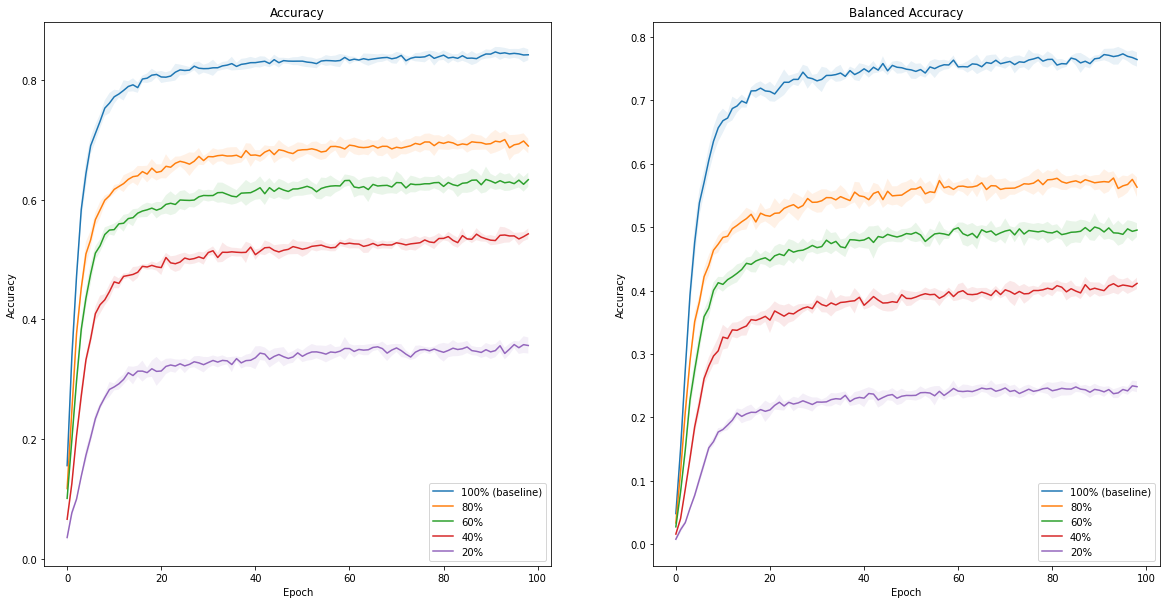

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline'], ax1, label='100% (baseline)', column='acc')
plot_df(dfs['baseline'], ax2, label='100% (baseline)', column='acc_bal')

plot_df(dfs['sample_80'], ax1, label='80%', column='acc')
plot_df(dfs['sample_80'], ax2, label='80%', column='acc_bal')


plot_df(dfs['sample_60'], ax1, label='60%', column='acc')
plot_df(dfs['sample_60'], ax2, label='60%', column='acc_bal')

plot_df(dfs['sample_40'], ax1, label='40%', column='acc')
plot_df(dfs['sample_40'], ax2, label='40%', column='acc_bal')

plot_df(dfs['sample_20'], ax1, label='20%', column='acc')
plot_df(dfs['sample_20'], ax2, label='20%', column='acc_bal')


ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')
